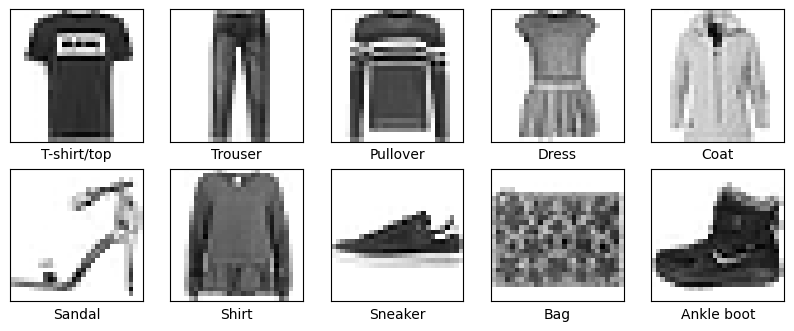

In [16]:
#importing essential libraries

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from keras.datasets import fashion_mnist
from keras.utils import to_categorical

#loading the datasets

(x_training_set, y_training_set), (x_testing_set, y_testing_set) = fashion_mnist.load_data()

#storing different classes in a list

classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#function definition to plot the one image from different classes

def plot_img(images, labels, classes):
  image_list = [] #list to store one image from each class
  class_num = len(classes)

  for i in range(class_num):
    indx = np.where(labels == i)[0][0]
    image_list.append(images[indx])

  #plotting the images

  plt.figure(figsize = (10,10))
  for i in range(class_num):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image_list[i], cmap=plt.cm.binary)
    plt.xlabel(classes[i])
  plt.show()


#calling the function

plot_img(x_training_set, y_training_set, classes)

In [17]:
#splitting the data for cross validation

x_validation_set = x_training_set[50000:]
y_validation_set = y_training_set[50000:]     # validation set has 10000 data

x_training_set = x_training_set[:50000]
y_training_set = y_training_set[:50000]


#vactorising the data

x_training_set = x_training_set.reshape(x_training_set.shape[0], 784)  #28x28 pixels = 784
x_testing_set = x_testing_set.reshape(x_testing_set.shape[0], 784)
x_validation_set = x_validation_set.reshape(x_validation_set.shape[0], 784)

#normalising the data

x_train = x_training_set/255  # since, pixel range from 0 to 255
x_test = x_testing_set/255
x_valid = x_validation_set/255

#one hot encoding for labels to represent categorical variables as numerical values

y_train = to_categorical(y_training_set)
y_test = to_categorical(y_testing_set)
y_valid = to_categorical(y_validation_set)


#default_x_train = x_train
#default_y_train = y_train

# some useful functions

#for hidden layer
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

def gradient_sigmoid(x):
  return sigmoid(x) * (1 - sigmoid(x))

#for output layer
def softmax(x):
  exponents = np.exp(x - np.max(x, axis=1, keepdims=True))
  return exponents / np.sum(exponents, axis=1, keepdims=True)


#loss function(cross-entropy)
def loss_func(x,y):
  L = -np.mean(np.sum(x * np.log(y), axis=1))
  return L

In [36]:
#class definition

class Network:
    def __init__(self, neuron_sizes, weight_initialiser, activation_function, momentum):

        self.train_loss_sgd = []
        self.train_loss_momentum = []


        self.total_layers = len(neuron_sizes)
        self.momentum = momentum

        # Initializing the weights and biases
        # After initializing, store weights and biases in separate lists
        if weight_initialiser == 'xavier':
            if activation_function != 'relu':
                self.Weights = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
                self.biases = [-1/np.sqrt(neuron_sizes[i])+np.random.randn(1, neuron_sizes[i+1])*2/np.sqrt(neuron_sizes[i]) for i in range(self.total_layers-1)]
            else:
                self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
                self.biases = [np.random.randn(1, neuron_sizes[i+1])*(np.sqrt(2/(neuron_sizes[i]))) for i in range(self.total_layers-1)]
        else:
            self.Weights = [np.random.randn(neuron_sizes[i], neuron_sizes[i+1]) for i in range(self.total_layers-1)]
            self.biases = [np.random.randn(1, neuron_sizes[i+1])*0.05 for i in range(self.total_layers-1)]

        # Initializing momentum weights and biases
        self.Weights_moment = [np.zeros_like(x) for x in self.Weights]
        self.biases_moment = [np.zeros_like(x) for x in self.biases]

        # Initializing Nesterov momentum adjusted weights and biases
        self.momentum_adjusted_Weights = None
        self.momentum_adjusted_biases = None

    # Defining function for forward propagation
    def forward_prop(self, X):
        self.pre_activations_A = [None]*(self.total_layers)  # List to store the pre-activations
        self.activations_H = [X]  # List to store the activations

        for i in range(self.total_layers-1):
            self.pre_activations_A[i+1] = np.dot(self.activations_H[i], self.Weights[i]) + self.biases[i]
            if i == self.total_layers-2:  # For output layer: activation function = softmax
                h = softmax(self.pre_activations_A[i+1])
                self.activations_H.append(h)
            else:  # For hidden layers: activation function = sigmoid
                h = sigmoid(self.pre_activations_A[i+1])
                self.activations_H.append(h)
        return self.activations_H[-1]

    #defining the training method for stochastic gradient method
    def train_sgd(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):
                # Forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                # Applying backpropagation algorithm
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.biases[j-1] - learning_rate_eta * gradient_b

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_sgd.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')


        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    # Defining the momentum-based gradient descent training method
    def train_momentum(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            loss_epo = 0
            for i in range(0, x_train.shape[0], batch_size):

                #performing the forward pass
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]
                y_predicted = self.forward_prop(Xbatch)

                #calculate loss
                loss = loss_func(Ybatch, y_predicted)
                loss_epo = loss_epo+loss

                #performing the back-propagation
                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    #updation of momentum
                    self.Weights_moment[j-1] = self.momentum * self.Weights_moment[j-1] + learning_rate_eta * gradient_W
                    self.biases_moment[j-1] = self.momentum * self.biases_moment[j-1] + learning_rate_eta * gradient_b

                    #updation of parameters
                    self.Weights[j-1] = self.Weights[j-1] - self.Weights_moment[j-1]
                    self.biases[j-1] = self.biases[j-1] - self.biases_moment[j-1]

            #computing average epoch loss
            loss_epo = loss_epo / (x_train.shape[0] / batch_size)
            self.train_loss_momentum.append(loss_epo)

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')

        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')

    #defining the training method for nesterov accelerated gradient descent method
    def train_nag(self, x_train, y_train, learning_rate_eta, total_epochs, batch_size):
        for epoch in range(total_epochs):
            for i in range(0, x_train.shape[0], batch_size):
                Xbatch = x_train[i:i+batch_size]
                Ybatch = y_train[i:i+batch_size]

                # Nesterov accelerated gradient descent: lookahead
                '''
                self.momentum_adjusted_Weights = [self.Weights[j-1] - self.momentum * self.Weights_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]
                self.momentum_adjusted_biases = [self.biases[j-1] - self.momentum * self.biases_moment[j-1] for j in range(self.total_layers - 1, 0, -1)]'''

                self.momentum_adjusted_Weights = [self.Weights[j] - self.momentum * self.Weights_moment[j] for j in range(self.total_layers-1)]
                self.momentum_adjusted_biases = [self.biases[j] - self.momentum * self.biases_moment[j] for j in range(self.total_layers-1)]
                '''
                print(self.momentum_adjusted_Weights[-1].shape)
                print(self.momentum_adjusted_Weights[-2].shape)
                print(self.momentum_adjusted_Weights[-3].shape)'''

                y_predicted = self.forward_prop(Xbatch)

                loss_gradient = y_predicted - Ybatch
                for j in range(self.total_layers - 1, 0, -1):
                    gradient_W = np.dot(self.activations_H[j-1].T, loss_gradient)
                    gradient_b = np.sum(loss_gradient, axis=0, keepdims=True)
                    if j > 1:
                        loss_gradient = np.dot(loss_gradient, self.momentum_adjusted_Weights[j-1].T) * (self.activations_H[j-1] * (1 - self.activations_H[j-1]))

                    self.Weights[j-1] = self.momentum_adjusted_Weights[j-1] - learning_rate_eta * gradient_W
                    self.biases[j-1] = self.momentum_adjusted_biases[j-1] - learning_rate_eta * gradient_b

            #computing accuracy on validation set
            y_valid_predicted = self.forward_prop(x_valid)
            valid_accuracy = accuracy_score(np.argmax(y_valid_predicted, axis=1), np.argmax(y_valid, axis=1))
            print(f'Epoch Number {epoch+1}, validation accuracy: {valid_accuracy:.4f}')

        #checking the efficiency of the model by passing test set
        y_test_predicted = self.forward_prop(x_test)
        test_accuracy = accuracy_score(np.argmax(y_test_predicted, axis = 1), np.argmax(y_test, axis = 1))
        print(f'Test Accuracy: {test_accuracy:.4f}')


In [37]:
neuron_sizes = [784, 64, 64, 10]

In [38]:
#initialization of the neural network by making an object of class Network

#for 'NAG'
my_model_NAG = Network(neuron_sizes, 'xavier', 'sigmoid', 0.9)

#envoking the function train_sgd
my_model_NAG.train_nag(x_train, y_train, 0.01, 20, 128)

Epoch Number 1, validation accuracy: 0.8011
Epoch Number 2, validation accuracy: 0.8326
Epoch Number 3, validation accuracy: 0.8473
Epoch Number 4, validation accuracy: 0.8541
Epoch Number 5, validation accuracy: 0.8596
Epoch Number 6, validation accuracy: 0.8642
Epoch Number 7, validation accuracy: 0.8667
Epoch Number 8, validation accuracy: 0.8699
Epoch Number 9, validation accuracy: 0.8708
Epoch Number 10, validation accuracy: 0.8725
Epoch Number 11, validation accuracy: 0.8742
Epoch Number 12, validation accuracy: 0.8739
Epoch Number 13, validation accuracy: 0.8746
Epoch Number 14, validation accuracy: 0.8747
Epoch Number 15, validation accuracy: 0.8743
Epoch Number 16, validation accuracy: 0.8722
Epoch Number 17, validation accuracy: 0.8723
Epoch Number 18, validation accuracy: 0.8724
Epoch Number 19, validation accuracy: 0.8722
Epoch Number 20, validation accuracy: 0.8719
Test Accuracy: 0.8665


In [4]:
#initialization of the neural network by making an object of class Network

#for 'sgd'
my_model_sgd = Network(neuron_sizes, 'xavier', 'sigmoid', 0)

#envoking the function train_sgd
my_model_sgd.train_sgd(x_train, y_train, 0.01, 20, 1)

Epoch Number 1, validation accuracy: 0.8002
Epoch Number 2, validation accuracy: 0.8321
Epoch Number 3, validation accuracy: 0.8439
Epoch Number 4, validation accuracy: 0.8476
Epoch Number 5, validation accuracy: 0.8454
Epoch Number 6, validation accuracy: 0.8452
Epoch Number 7, validation accuracy: 0.8465
Epoch Number 8, validation accuracy: 0.8494
Epoch Number 9, validation accuracy: 0.8532
Epoch Number 10, validation accuracy: 0.8580
Epoch Number 11, validation accuracy: 0.8597
Epoch Number 12, validation accuracy: 0.8616
Epoch Number 13, validation accuracy: 0.8619
Epoch Number 14, validation accuracy: 0.8625
Epoch Number 15, validation accuracy: 0.8631
Epoch Number 16, validation accuracy: 0.8633
Epoch Number 17, validation accuracy: 0.8644
Epoch Number 18, validation accuracy: 0.8650
Epoch Number 19, validation accuracy: 0.8653
Epoch Number 20, validation accuracy: 0.8647
Test Accuracy: 0.8560


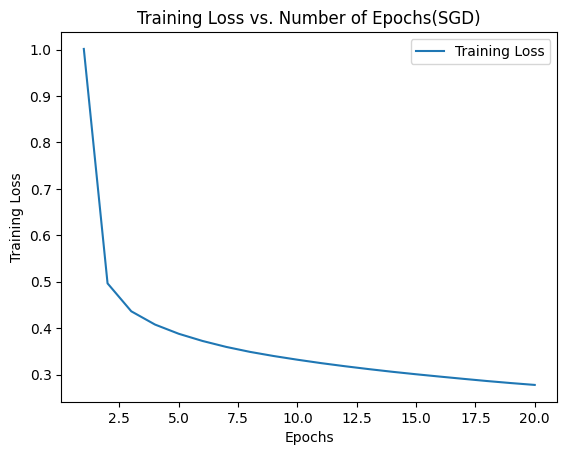

In [6]:
# Plot training loss vs. number of epochs
plt.plot(range(1, 21), my_model_sgd.train_loss_sgd, label='Training Loss')
plt.title('Training Loss vs. Number of Epochs(SGD)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

In [14]:
#for 'mgd'

my_model_momentum = Network(neuron_sizes, 'xavier', 'sigmoid', 0.9)

#envoking the function train_momentum

my_model_momentum.train_momentum(x_train, y_train, 0.01, 30, 128)

Epoch Number 1, validation accuracy: 0.7585
Epoch Number 2, validation accuracy: 0.8000
Epoch Number 3, validation accuracy: 0.7901
Epoch Number 4, validation accuracy: 0.7777
Epoch Number 5, validation accuracy: 0.8212
Epoch Number 6, validation accuracy: 0.8088
Epoch Number 7, validation accuracy: 0.8337
Epoch Number 8, validation accuracy: 0.8113
Epoch Number 9, validation accuracy: 0.8105
Epoch Number 10, validation accuracy: 0.8230
Epoch Number 11, validation accuracy: 0.8412
Epoch Number 12, validation accuracy: 0.8389
Epoch Number 13, validation accuracy: 0.8200
Epoch Number 14, validation accuracy: 0.8248
Epoch Number 15, validation accuracy: 0.8334
Epoch Number 16, validation accuracy: 0.8417
Epoch Number 17, validation accuracy: 0.8358
Epoch Number 18, validation accuracy: 0.8459
Epoch Number 19, validation accuracy: 0.8398
Epoch Number 20, validation accuracy: 0.8369
Epoch Number 21, validation accuracy: 0.8339
Epoch Number 22, validation accuracy: 0.8371
Epoch Number 23, va

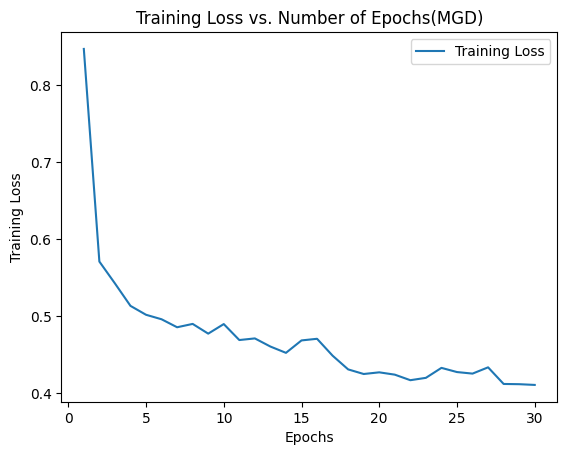

In [15]:
# Plot training loss vs. number of epochs
plt.plot(range(1, 31), my_model_momentum.train_loss_momentum, label='Training Loss')
plt.title('Training Loss vs. Number of Epochs(MGD)')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()